# CNN实现CIFAR-10图像分类



## 1.环境及依赖导入

In [1]:
# 环境与依赖
import os, tarfile, pickle
from pathlib import Path
import torch, torch.nn as nn, torch.optim as optim
from torchvision import transforms, datasets, models
from tqdm import tqdm
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device ->", DEVICE)

Using device -> cuda


## 2.数据集预处理

In [2]:
# 数据准备
DATA_DIR   = Path("./data")                      # 统一的根目录
RAW_DIR    = DATA_DIR / "cifar-10-batches-py"    # 解压后应出现的文件夹

if RAW_DIR.exists():
    print("已检测到解压后的 CIFAR‑10 batch 文件")

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tf = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

BATCH_SIZE  = 128
NUM_WORKERS = 4

train_set = datasets.CIFAR10(root=str(DATA_DIR), train=True,
                             transform=train_tf)
test_set  = datasets.CIFAR10(root=str(DATA_DIR), train=False,
                             transform=test_tf)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")

已检测到解压后的 CIFAR‑10 batch 文件
Train size: 50000, Test size: 10000


## 3.模型构建
模型在AlexNet的基础上改进，通过添加BatchNorm层来提升模型表现。

In [3]:
# 模型构建 (AlexNet‑BN)

class AlexNetBN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 192, 3, padding=1), nn.BatchNorm2d(192), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 384, 3, padding=1), nn.BatchNorm2d(384), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*28*28, 4096), nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

model = AlexNetBN().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters())/1e6
print(f"Model params: {total_params:.2f} M")

Model params: 841.16 M


## 4.训练参数设置

In [10]:
# 训练及验证配置
EPOCHS = 30
LR      = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def evaluate(net, loader):
    net.eval()
    num_classes = 10
    # 初始化混淆矩阵
    confmat = torch.zeros((num_classes, num_classes), dtype=torch.int64, device=DEVICE)
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = net(x).argmax(dim=1)
            # 先计算一维 bincount，再 reshape
            idxs = y * num_classes + pred
            binc = torch.bincount(idxs, minlength=num_classes**2)
            confmat += binc.view(num_classes, num_classes)
    # 计算总体 Accuracy
    correct = confmat.diag().sum().item()
    total   = confmat.sum().item()
    acc = correct / total
    # 计算每类 Precision
    precision = {}
    for i in range(num_classes):
        tp = confmat[i, i].item()
        fp = confmat[:, i].sum().item() - tp
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    return acc, precision

print("训练参数设定：Epoch=",EPOCHS,",Learning Rate=",LR)

训练参数设定：Epoch= 30 ,Learning Rate= 0.01


## 5.模型训练

In [11]:
# 主训练循环
acc_list, precision_hist, best_acc = [], [], 0.0

for epoch in range(1, EPOCHS+1):
    model.train(); running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(imgs), labels)
        loss.backward(); optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    scheduler.step()
    train_loss = running_loss / len(train_set)
    acc, prec = evaluate(model, test_loader)
    acc_list.append(acc); precision_hist.append(prec)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_cifar_alexnet.pth")
    print(f"Epoch {epoch:02d} | TrainLoss {train_loss:.4f} | TestAcc {acc*100:.2f}%")

print(f"Best TestAcc = {best_acc*100:.2f}%")

Epoch 01 | TrainLoss 1.4471 | TestAcc 52.65%


Epoch 02 | TrainLoss 1.3113 | TestAcc 58.10%


Epoch 03 | TrainLoss 1.2109 | TestAcc 60.66%


Epoch 04 | TrainLoss 1.1185 | TestAcc 61.86%


Epoch 05 | TrainLoss 1.0622 | TestAcc 67.94%


Epoch 06 | TrainLoss 0.9906 | TestAcc 67.84%


Epoch 07 | TrainLoss 0.9436 | TestAcc 70.87%


Epoch 08 | TrainLoss 0.8953 | TestAcc 73.31%


Epoch 09 | TrainLoss 0.8532 | TestAcc 73.48%


Epoch 10 | TrainLoss 0.8152 | TestAcc 74.59%


Epoch 11 | TrainLoss 0.7010 | TestAcc 79.08%


Epoch 12 | TrainLoss 0.6720 | TestAcc 79.53%


Epoch 13 | TrainLoss 0.6564 | TestAcc 79.94%


Epoch 14 | TrainLoss 0.6478 | TestAcc 79.88%


Epoch 15 | TrainLoss 0.6357 | TestAcc 80.20%


Epoch 16 | TrainLoss 0.6257 | TestAcc 80.81%


Epoch 17 | TrainLoss 0.6220 | TestAcc 80.70%


Epoch 18 | TrainLoss 0.6091 | TestAcc 80.84%


Epoch 19 | TrainLoss 0.6071 | TestAcc 80.89%


Epoch 20 | TrainLoss 0.5990 | TestAcc 81.10%


Epoch 21 | TrainLoss 0.5840 | TestAcc 81.40%


Epoch 22 | TrainLoss 0.5771 | TestAcc 81.43%


Epoch 23 | TrainLoss 0.5787 | TestAcc 81.40%


Epoch 24 | TrainLoss 0.5752 | TestAcc 81.56%


Epoch 25 | TrainLoss 0.5748 | TestAcc 81.84%


Epoch 26 | TrainLoss 0.5724 | TestAcc 81.64%


Epoch 27 | TrainLoss 0.5691 | TestAcc 81.62%


Epoch 28 | TrainLoss 0.5679 | TestAcc 81.70%


Epoch 29 | TrainLoss 0.5676 | TestAcc 81.61%


Epoch 30 | TrainLoss 0.5648 | TestAcc 81.82%
Best TestAcc = 81.84%


## 6.评价指标及可视化

In [12]:
# 保存评价指标
with open("metrics.pkl", "wb") as f:
    pickle.dump({"acc_list": acc_list, "precision_hist": precision_hist}, f)
print("Metrics saved to metrics.pkl")

Metrics saved to metrics.pkl


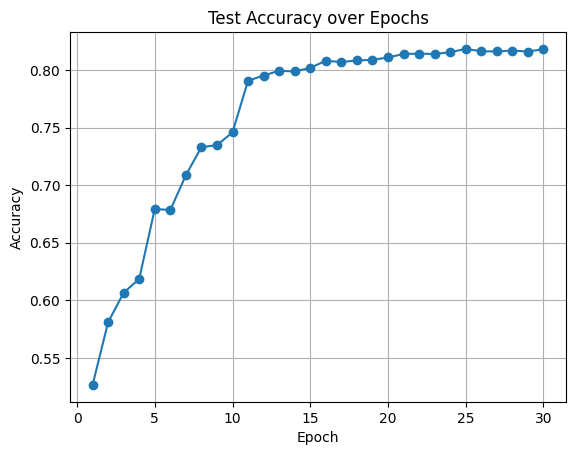

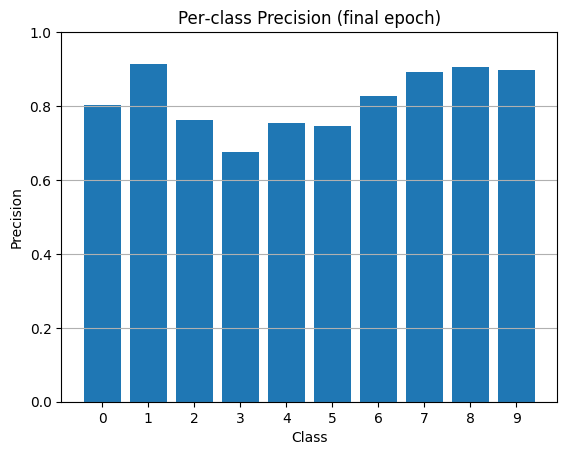

In [13]:
# 作图
epochs = range(1, len(acc_list)+1)

plt.figure(); plt.plot(epochs, acc_list, marker='o')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Test Accuracy over Epochs")
plt.grid(True)

final_prec = precision_hist[-1]
classes = list(final_prec.keys()); prec_vals = [final_prec[c] for c in classes]
plt.figure(); plt.bar(classes, prec_vals)
plt.xticks(classes); plt.xlabel("Class"); plt.ylabel("Precision")
plt.title("Per‑class Precision (final epoch)"); plt.ylim(0,1); plt.grid(axis='y')
plt.show()